<a href="https://colab.research.google.com/github/popitree/deep-learning/blob/master/3_Regression_Boston_Housing_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.datasets import boston_housing

In [3]:
(train_data, train_target), (test_data,test_target) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [4]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
print(train_data[0:2])
train_target[:10]

[[1.23247e+00 0.00000e+00 8.14000e+00 0.00000e+00 5.38000e-01 6.14200e+00
  9.17000e+01 3.97690e+00 4.00000e+00 3.07000e+02 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 0.00000e+00 4.15000e-01 7.61000e+00
  1.57000e+01 6.27000e+00 2.00000e+00 3.48000e+02 1.47000e+01 3.95380e+02
  3.11000e+00]]


array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [0]:
# So we have numerical data only but of different scale
# let us standardize the data for each column
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# we will use the same value to standardize test data
# We should not use any quantity that is computed on test data

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

 

In [0]:
# NW Building
# We will use small NW. 2 hidden layers of 16 each
# The less data we have more chance of overfitting, using small NW is one way of mitigating that

from tensorflow.keras import models
from tensorflow.keras import layers


In [0]:
# we will have to use same model multiple times so lets create a function to instantiate it

def build_model():
  model = models.Sequential(layers=layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64,activation='relu'))
  model.add(layers.Dense(1))
  # ends with 1 layer and no activation, typical setup for regression
  # last layer is purely linear, can take any range
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  # Loss is mean squared error, very good for regression
  # metric MAE Mean Absolute Error, ie if it is 0.5 it is off by 0.5 on average
  
  return model


In [0]:
# As data points are very less, if we keep validation set aside and train the score on validation set may change a lot
# depending on what we kept for training and what for validation
# So best is K-Fold validation
# And overall validation score is the average of score on all those validation sets
import numpy as np
k=4
num_value_samples = len(train_data) // 4
num_epochs = 100
all_mse_scores = []
all_mae_scores = []

for i in range(k):
  print("Processing Fold: ", i)
  val_data = train_data[i*num_value_samples : (i+1)*num_value_samples]
  val_target = train_target[i*num_value_samples : (i+1)*num_value_samples]

  # data from before and after validation slice
  partial_train_data = np.concatenate(
      [
       train_data[:i*num_value_samples],
       train_data[(i+1)*num_value_samples :]
       ], axis = 0
       )

  partial_train_target = np.concatenate(
       [
       train_target[:i*num_value_samples],
       train_target[(i+1)*num_value_samples :]
       ], axis = 0
       )

  model = build_model()

  model.fit(x=partial_train_data, y = partial_train_target, 
            batch_size=1,
            epochs = num_epochs,
            verrbose = 0)
  val_mse, val_mae = model.evaluate(x = val_data, y = val_target)  
  all_mse_scores.append(val_mse)
  all_mae_scores.append(val_mae)


In [16]:
print(all_mse_scores)
print(all_mae_scores)
print(np.mean(all_mae_scores))

[10.191424369812012, 13.047433853149414, 12.787456512451172, 9.762190818786621]
[2.3041069507598877, 2.668144702911377, 2.5089333057403564, 2.5081615447998047]
2.4973366260528564


In [0]:
# The price range is 10K to 50K, and on average we are off by 2.5*1K = $2500
# Let us run the model little longer, 500 epochs.
# To check how it performs we will keep a track of validation score for each epoch

all_mae_histories = []
num_epochs = 500

for i in range(k):
  print("Processing Fold: ", i)
  val_data = train_data[i*num_value_samples : (i+1)*num_value_samples]
  val_target = train_target[i*num_value_samples : (i+1)*num_value_samples]

  # data from before and after validation slice
  partial_train_data = np.concatenate(
      [
       train_data[:i*num_value_samples],
       train_data[(i+1)*num_value_samples :]
       ], axis = 0
       )

  partial_train_target = np.concatenate(
       [
       train_target[:i*num_value_samples],
       train_target[(i+1)*num_value_samples :]
       ], axis = 0
       )

  model = build_model()

  history = model.fit(x=partial_train_data, y = partial_train_target, 
                      validation_data = (val_data, val_target),
                      batch_size=1,
                      epochs = num_epochs,
                      verrbose = 0)
  #print(history.history.keys())
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

In [20]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [0]:
# WHat is the avg MAE error for each epoch across 4 validation sets
average_mae_history  = [
                        np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
                        ]

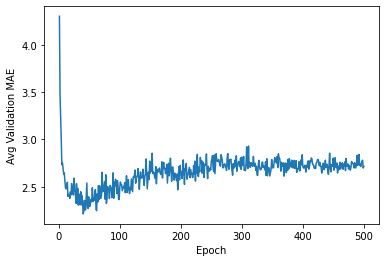

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel("Epoch")
plt.ylabel("Avg Validation MAE")
plt.show()

In [0]:
# Difficult to see the plot due to scaling issue and relatively high VARiance
# Replace first 10 points which are way too high
# Replace each point with an exponential moving avg of all previous points to get a smooth curve
def smooth_curve(points, factor = 0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

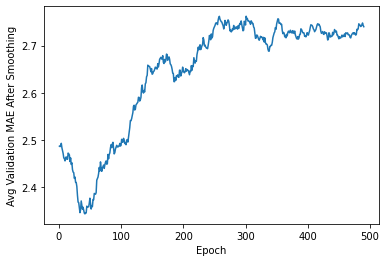

In [31]:
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel("Epoch")
plt.ylabel("Avg Validation MAE After Smoothing")
plt.show()

In [0]:
# Validation MAE stops improving significantly after 80 epochs
# Once tuning of params done we can also adjust hidden layers size

# Let us build final model and check its performance on test data

In [39]:
model = build_model()
model.fit(x = train_data,
          y=train_target,
          epochs = 80,
          batch_size = 1,
          verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)

4/4 [==============================] - 0s 2ms/step - loss: 38.7311 - mae: 2.5515


In [38]:
test_mae_score

2.642787218093872

In [0]:
# So we are still of by $2550